# 1. Setup

#### Bibliotecas principais
- A biblioteca `os` é um **sistema operacional** que vai ser utilizado na criação de estrutura de pastas
- Numpy é utlizado para manipular **arrays**
- Matplotlib para plotar os gráficos

## 1.1 Install Dependencies

In [207]:
 # %pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [208]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

### O que são Redes Neurais Siamesas?

Redes Neurais Siamesas (RNS) foram introduzidas por Bromley em colaboração, no ano de 1994, onde foram utilizadas para realizara veriﬁcação de assinaturas. A arquitetura de uma RNS, consiste em duas redes neurais que compartilham pesos idênticos e que são ligadas por uma ou mais camadas. Na maioria dos casos, uma RNS executa uma codiﬁcação não linear dos dados de entrada com o objetivo de atingir um espaço semanticamente signiﬁcativo onde padrões relacionados sejam próximos uns dos outros (tais como faces de pessoas, assinaturas,entre outros) e os não relacionados sejam distantes unsdos dos outros (Harandi et al., 2017).

- `from tensorflow.keras.models import Model` importa Modelos e agrupa camadas em um objeto com recursos de treinamento e inferência. Ele recebe a imagem de `input` a retorna **0** se a imagem for diferente e **1** se for igual no `output`

- `from tensorflow.keras.layers` importa as camadas possibilitando a criação de uma camada personalizada chamada `L1Dist`
  - Conv2D: utilizada para criar uma rede neural convolucional;
  - Dense: camada conectada;
  - MaxPooling2D: permite juntar as camadas e escolhe as informações que realmente são necessárias. Semelhante a uma média;
  - Input: a entrada do algoritmo;
  - Flatten: leva as informações de uma camada anterior, "achata" em uma única dimensão, que permite enviar os dados de uma rede convolucionoal para uma camada densa.

In [209]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

### Configuração da GPU

In [210]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## 1.4 Create Folder Structures

O algoritmo utiliza 3 pastas.
- Âncora
- Positivo
- Negativo

Na pasta âncora está a imagem que define quem nós somos. Na pasta positivo, está a imagem que confirmará se a o arquivo da pasta âncora é correto. Negativo são os que não se assemelham com o arquivo da pasta âncora.

In [211]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [212]:
# Make the directories
#os.makedirs(POS_PATH)
#os.makedirs(NEG_PATH)
#os.makedirs(ANC_PATH)

# 2. Collect Positives and Anchors

## 2.1 Untar Labelled Faces in the Wild Dataset

In [213]:
#http://vis-www.cs.umass.edu/lfw/

In [214]:
# Uncompress Tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz

In [215]:
# Mova as imagens LFW para os seguintes dados/negativos do repositório
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## 2.2 Collect Positive and Anchor Classes

In [216]:
# Importe a biblioteca uuid para gerar nomes de imagem exclusivos
import uuid

In [217]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\386df079-7188-11ed-bc4e-6432a87b22d4.jpg'

In [218]:
# Conecta webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    frame = frame[120:120+250,200:200+250, :]
    
    # ancoras 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Crie o caminho de arquivo exclusivo
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Escreva a imagem da âncora
        cv2.imwrite(imgname, frame)
    
    # positivos
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Crie o caminho de arquivo exclusivo
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Escreva a imagem da positiva
        cv2.imwrite(imgname, frame)
    
    # Mostrar imagem de volta à tela
    cv2.imshow('Image Collection', frame)
    
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

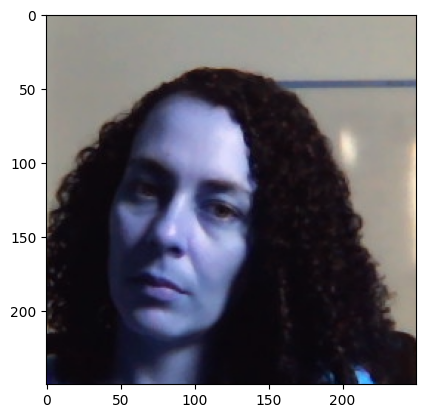

In [219]:
plt.imshow(frame)

# 2.x NEW - Data Augmentation

In [220]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data

In [221]:
import os
import uuid

In [222]:
img_path = os.path.join(ANC_PATH, 'f2bfd8c3-7184-11ed-8dc8-6432a87b22d4.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
       cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [223]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(3000)

In [224]:
dir_test = anchor.as_numpy_iterator()

In [225]:
print(dir_test.next())

b'data\\anchor\\570f0444-7188-11ed-8385-6432a87b22d4.jpg'


## 3.2 Preprocessing - Scale and Resize

In [226]:
def preprocess(file_path):
    
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    
    img = tf.image.resize(img, (100,100))
    img = img / 255.0

    return img

In [227]:
img = preprocess('data\\anchor\\f2bfd8c3-7184-11ed-8dc8-6432a87b22d4.jpg')

In [228]:
img.numpy().max() 

0.95416665

## 3.3 Create Labelled Dataset

In [229]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [230]:
samples = data.as_numpy_iterator()

In [231]:
exampple = samples.next()

In [232]:
exampple

(b'data\\anchor\\5668ae72-7188-11ed-b4ca-6432a87b22d4.jpg',
 b'data\\positive\\502e6bcb-7188-11ed-b691-6432a87b22d4.jpg',
 1.0)

## 3.4 Build Train and Test Partition

In [233]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [234]:
res = preprocess_twin(*exampple)

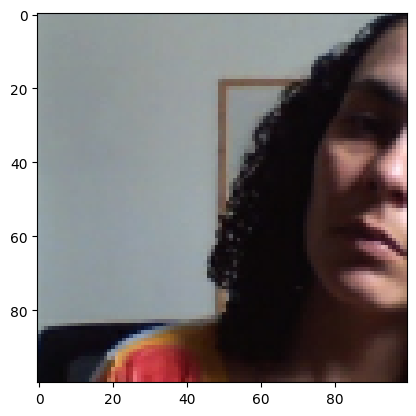

In [235]:
plt.imshow(res[1])

In [236]:
res[2]

1.0

In [237]:
# Carregando pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [238]:
# Partição de treinamento
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [239]:
# Partição de teste
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [240]:
inp = Input(shape=(100,100,3), name='input_image')

In [241]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [242]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [243]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [244]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [245]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [246]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [247]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 17, 17, 128)       26

In [248]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # primeiro block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # segundo block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # terceiro block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Bloco de incorporação final
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [249]:
embedding = make_embedding()

In [250]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 46, 46, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 20, 20, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 17, 17, 128)       26

## 4.2 Build Distance Layer

In [251]:
# Classificação da distancia siamesa L1
class L1Dist(Layer):
    
    def __init__(self, **kwargs):
        super().__init__()
       
    # calcula similaridade
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [252]:
l1 = L1Dist()

In [253]:
# l1(anchor_embedding, validation_embedding)

## 4.3 Make Siamese Model

In [254]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [255]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [256]:
siamese_layer = L1Dist()

In [257]:
distances = siamese_layer(inp_embedding, val_embedding)

In [258]:
classifier = Dense(1, activation='sigmoid')(distances)

In [259]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_10')>

In [260]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [261]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [262]:
def make_siamese_model(): 
    
    # entrada da imagem ancora na rede
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # validaçao da imagem na rede 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # combinação das distancias dos componentes
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # camada de classificação 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [263]:
siamese_model = make_siamese_model()

In [264]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

### Treino do modelo

## 5.1 Setup Loss and Optimizer

In [265]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [266]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## 5.2 Establish Checkpoints

In [267]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [268]:
test_batch = train_data.as_numpy_iterator()

In [269]:
batch_1 = test_batch.next()

In [270]:
X = batch_1[:2]

In [271]:
y = batch_1[2]

In [272]:
y

array([0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.],
      dtype=float32)

In [273]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

## 5.4 Build Training Loop

In [274]:
from tensorflow.keras.metrics import Precision, Recall

In [275]:
def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        r = Recall()
        p = Precision()
        
        # Percorra cada lote
        for idx, batch in enumerate(data):
            # executa o passo de treino
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # salva checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [276]:
EPOCHS = 50

In [277]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
5/5 [==============================] - 98s 20s/step
0.69059724 0.34210527 1.0

 Epoch 2/50
5/5 [==============================] - 105s 21s/step
0.5265919 0.21212122 1.0

 Epoch 3/50
5/5 [==============================] - 100s 20s/step
0.49931955 0.45714286 1.0

 Epoch 4/50
5/5 [==============================] - 105s 20s/step
0.43753046 0.71794873 1.0

 Epoch 5/50
5/5 [==============================] - 104s 21s/step
0.13158558 0.84375 0.96428573

 Epoch 6/50
5/5 [==============================] - 105s 21s/step
0.15029752 0.8947368 1.0

 Epoch 7/50
5/5 [==============================] - 105s 21s/step
0.16681962 0.9166667 0.9705882

 Epoch 8/50
5/5 [==============================] - 105s 20s/step
0.29005426 0.9459459 1.0

 Epoch 9/50
5/5 [==============================] - 104s 21s/step
0.11737887 0.9655172 1.0

 Epoch 10/50


# 6. Evaluate Model

## 6.1 Import Metrics

In [278]:
# Importar cálculos de métricas
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [279]:
# Obter um lote de dados de teste
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [280]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 [==============================] - 2s 2s/step


In [281]:
# Pós-processamento dos resultados
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]

In [282]:
y_true

array([1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
      dtype=float32)

## 6.3 Calculate Metrics

In [283]:
m = Recall()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [284]:
m = Precision()

m.update_state(y_true, y_hat)

m.result().numpy()

1.0

In [285]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 [==============================] - 4s 4s/step
1.0 1.0


## 6.4 Viz Results

### Visualizando os resultados

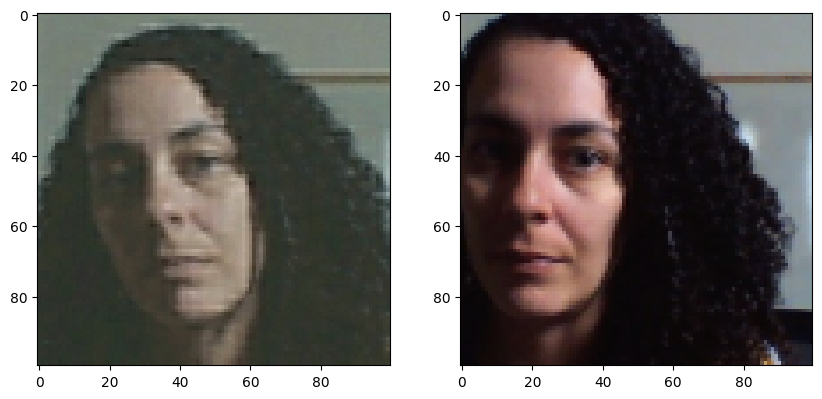

In [286]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[0])

plt.subplot(1,2,2)
plt.imshow(test_val[0])

plt.show()

# 7. Save Model

In [287]:
# Salvar pesos
siamese_model.save('siamesemodelv2.h5')

In [288]:
L1Dist

__main__.L1Dist

In [289]:
# Recarregando o modelo
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [290]:
# previsões com modelo recarregado
siamese_model.predict([test_input, test_val])

1/1 [==============================] - 3s 3s/step


array([[9.9986708e-01],
       [1.2224484e-05],
       [3.0170177e-08],
       [9.9991536e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [5.4687862e-06],
       [1.9868924e-06],
       [9.9998426e-01],
       [5.0871247e-05],
       [9.9967921e-01],
       [1.0000000e+00],
       [2.6061754e-05],
       [9.9991953e-01],
       [2.7964902e-03]], dtype=float32)

In [291]:
# resumo do modelo
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [292]:
# application_data//verification_images

In [293]:
os.listdir(os.path.join('application_data', 'C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images'))

['4b783c73-7188-11ed-a91a-6432a87b22d4.jpg',
 '4ba2b8de-7188-11ed-8ef4-6432a87b22d4.jpg',
 '4c4920a6-7188-11ed-ae57-6432a87b22d4.jpg',
 '4c6d4a45-7188-11ed-8b9b-6432a87b22d4.jpg',
 '4c90a94f-7188-11ed-abd7-6432a87b22d4.jpg',
 '4cd828d9-7188-11ed-ad95-6432a87b22d4.jpg',
 '4d4a7a26-7188-11ed-885b-6432a87b22d4.jpg',
 '4da6f5cb-7188-11ed-9cae-6432a87b22d4.jpg',
 '4df2ea50-7188-11ed-baba-6432a87b22d4.jpg',
 '4e169155-7188-11ed-85bf-6432a87b22d4.jpg',
 '4e3a3dc4-7188-11ed-aefa-6432a87b22d4.jpg',
 '4e88ce4a-7188-11ed-9876-6432a87b22d4.jpg',
 '4ef18675-7188-11ed-b9bf-6432a87b22d4.jpg',
 '4f7b7bf9-7188-11ed-8b6e-6432a87b22d4.jpg',
 '4fdf9c1b-7188-11ed-9ddc-6432a87b22d4.jpg',
 '502e6bcb-7188-11ed-b691-6432a87b22d4.jpg',
 '50d78d82-7188-11ed-bb39-6432a87b22d4.jpg',
 '5102732d-7188-11ed-b31c-6432a87b22d4.jpg',
 '512d0a72-7188-11ed-969f-6432a87b22d4.jpg',
 '519823bb-7188-11ed-b5c1-6432a87b22d4.jpg',
 '557f8528-7188-11ed-9307-6432a87b22d4.jpg',
 '55a34473-7188-11ed-bcfb-6432a87b22d4.jpg',
 '572cabd3

In [294]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [295]:
for image in os.listdir(os.path.join('application_data', 'C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images')):
    validation_img = os.path.join('application_data', 'C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images', image)
    print(validation_img)

C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images\4b783c73-7188-11ed-a91a-6432a87b22d4.jpg
C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images\4ba2b8de-7188-11ed-8ef4-6432a87b22d4.jpg
C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images\4c4920a6-7188-11ed-ae57-6432a87b22d4.jpg
C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images\4c6d4a45-7188-11ed-8b9b-6432a87b22d4.jpg
C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images\4c90a94f-7188-11ed-abd7-6432a87b22d4.jpg
C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images\4cd828d9-7188-11ed-ad95-6432a87b22d4.jpg
C:/Users/rayan/Documents/machinelearning/facial-recognitio

In [296]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'C:/Users/rayan/Documents/machinelearning/facial-recognition-app/FaceIDApp-main/application_data/verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [297]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 264ms/step
True


In [298]:
np.sum(np.squeeze(results) > 0.9)

55

In [299]:
results

[array([[0.9984951]], dtype=float32),
 array([[0.99780875]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.9999994]], dtype=float32),
 array([[0.999998]], dtype=float32),
 array([[0.99999696]], dtype=float32),
 array([[0.953534]], dtype=float32),
 array([[0.99999934]], dtype=float32),
 array([[0.79587823]], dtype=float32),
 array([[0.92897207]], dtype=float32),
 array([[0.9785467]], dtype=float32),
 array([[0.99952096]], dtype=float32),
 array([[0.99505764]], dtype=float32),
 array([[0.99125475]], dtype=float32),
 array([[0.01498939]], dtype=float32),
 array([[0.9974914]], dtype=float32),
 array([[0.06391796]], dtype=float32),
 array([[0.04370213]], dtype=float32),
 array([[0.18258794]], dtype=float32),
 array([[0.99831825]], dtype=float32),
 array([[0.999966]], dtype=float32),
 array([[0.99999857]], dtype=float32),
 array([[0.71439457]], dtype=float32),
 array([[0.0018793]], dtype=float32),
 array([[0.9999363]], dtype=float32),
 array([[0.99999994]], dtype=float32),